In [2]:
import os
from types import FunctionType
import numpy as np
import pandas as pd
import scipy.linalg
from scipy.optimize import LinearConstraint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [27]:
def get_gt(n_traj=10,n_state=3,len=10):
    p_gt = np.random.rand(n_state,n_state)       
    p_gt = (p_gt.T/p_gt.sum(axis=1)).T
    p_gt = np.where(np.isnan(p_gt), 0, p_gt)

    p = np.zeros([n_state,n_state])
    for i in range(n_state):
        for j in range(n_state):
            if j == 0:
                p[i,j] = p_gt[i,j]
            else:
                p[i,j] = p[i,j-1] + p_gt[i,j]

    # initial state
    traj = np.zeros([n_traj,len])
    for k in range(n_traj):
        s = np.random.randint(n_state)
        traj[k,0] = s + 1
        for i in range(1,len):      
            # print("p[k]", p[k])
            s = get_next_state(s,p)
            traj[k,i] = s + 1
            # if s != 0:
            #     counter += 1
    #         print(counter)
    return traj , p_gt

def get_mdp_gt(n_traj=10,n_state=3,n_action=3,len=10):
    p_gt = np.random.rand(n_state,n_state*n_action)       
    p_gt = (p_gt.T/p_gt.sum(axis=1)).T
    p_gt = np.where(np.isnan(p_gt), 0, p_gt)

    p = np.zeros([n_state,n_state])
    for i in range(n_state):
        for j in range(n_state):
            if j == 0:
                p[i,j] = p_gt[i,j]
            else:
                p[i,j] = p[i,j-1] + p_gt[i,j]

    # initial state
    traj = np.zeros([n_traj,len,2])
    for k in range(n_traj):
        s = np.random.randint(n_state)
        a = np.random.randint(n_action)
        traj[k,0] = [s + 1, a]
        for i in range(1,len):      
            # print("p[k]", p[k])
            s = get_next_mdp_state(s,a,p)
            traj[k,i] = [s + 1,a]
            # if s != 0:
            #     counter += 1
    #         print(counter)
    return traj , p_gt

def get_p_k(n_traj=3,n_state=3,good_p_k=np.zeros([1,3,3]) ):
    n_good = len(good_p_k)
    print("n_good",n_good)
#     p = np.zeros([n_traj,n_state,n_state])
#   p: cdf   p_k:pdf
    p = np.zeros([n_traj+n_good,n_state,n_state])   
    p_k = np.zeros([n_traj+n_good,n_state,n_state])   
#     p_k = np.random.rand(n_traj+n_good,n_state,n_state)
    for k in range(n_traj):
        for i in range(n_state):
            for j in range(n_state):
                temp = np.random.rand()
                if temp > 0.5:
                    p_k[k,i,j] = 1
                else:
                    p_k[k,i,j] = 0
                if j == 0:
                    p[k,i,j] = p_k[k,i,j]
                else:
                    p[k,i,j] = p[k,i,j-1] + p_k[k,i,j]
            p[k,i,:] = p[k,i,:] / p[k,i,n_state-1] 
        p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T
        p_k[k] = np.where(np.isnan(p_k[k]), 0, p_k[k])
        # print("p_gt",p_gt[k])
    p_k[-n_good:] = good_p_k

    return  p_k

def get_next_state(i,p):
    prob = np.random.rand()
    for j in range(len(p)):
        # print("p[i,j]",p[i,j])
        if prob < p[i,j]:
            return j
    return j

def get_next_mdp_state(i,a,p):
    prob = np.random.rand()
    for j in range(len(p)):
        # print("p[i,j]",p[i,j])
        print((j-1)*3+a-1)
        if prob < p[i,(j-1)*3+a-1]:
            return j
    return j

def get_p_bar(traj, n_state):
    # total = (len(traj[0])-1)
    p_bar = np.zeros([n_state,n_state])
    # print("traj[0]",len(traj))
    # print("traj[1]",len(traj[1]))
    for k in range(len(traj)):
        for i in range(len(traj[1])-1):
            p_bar[int(traj[k,i])-1,int(traj[k,i+1])-1] += 1
    p_bar = (p_bar.T/p_bar.sum(axis=1)).T
    p_bar = np.where(np.isnan(p_bar), 0, p_bar)
    return p_bar

def get_alpha(p_bar,p_k):
    n = len(p_k)
    # print("n",n)
    x0 = np.array([1/n]*n)
    # print("x0",x0)
    res = least_squares(fun, x0, bounds=(0, 1),args=(p_bar, p_k), verbose=1)
    alpha = res.x/sum(res.x)
    return alpha

def model(x, p_k):
    sum = 0
    for i in range(len(x)):
        sum += p_k[i]*x[i]
    return sum

def fun(x,p_bar,p_k):
    return sum((model(x, p_k) - p_bar)**2)

def get_p_hat(alpha,p_k):
    sum = 0
    for i in range(len(alpha)):
        sum += p_k[i]*alpha[i]
    return sum

def get_error(p_hat,Frobenius_gt):
    delta = p_hat - p_gt
#     print("delta",delta)
    Frobenius_delta = np.linalg.norm(delta)
    
#     print("Frobenius_gt",Frobenius_gt)
    error = Frobenius_delta/Frobenius_gt
    
    return error


In [8]:
# num of states
n = 5

traj, p_gt = get_gt(n_traj=1000,n_state=n,len=3000)
print("p_gt",p_gt)
Frobenius_gt = np.linalg.norm(p_gt)
print("Frobenius_gt",Frobenius_gt)
p_bar = get_p_bar(traj, n_state=n) 


p_gt [[0.2855788  0.34445257 0.01583821 0.15595936 0.19817106]
 [0.07456254 0.59324259 0.04204842 0.19268052 0.09746592]
 [0.05816867 0.47405355 0.06400911 0.20190529 0.20186338]
 [0.17336635 0.18951019 0.12693766 0.24766985 0.26251595]
 [0.02090649 0.26656046 0.3312915  0.33869999 0.04254157]]
Frobenius_gt 1.2221996166142501


n_good 1
[[[0.25       0.25       0.         0.25       0.25      ]
  [0.5        0.         0.         0.5        0.        ]
  [0.         0.5        0.         0.         0.5       ]
  [0.         0.5        0.         0.5        0.        ]
  [0.         0.33333333 0.33333333 0.33333333 0.        ]]

 [[0.33333333 0.33333333 0.         0.         0.33333333]
  [0.         0.         0.5        0.         0.5       ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.5        0.5        0.         0.        ]
  [0.         0.33333333 0.33333333 0.33333333 0.        ]]

 [[0.         0.25       0.25       0.25       0.25      ]
  [0.         0.         0.         1.         0.        ]
  [0.25       0.         0.25       0.25       0.25      ]
  [0.25       0.25       0.25       0.25       0.        ]
  [0.         0.5        0.         0.5        0.        ]]

 [[0.5        0.5        0.         0.         0.        ]
  [0.         0.         0.5        0.   

C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:76: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:77: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


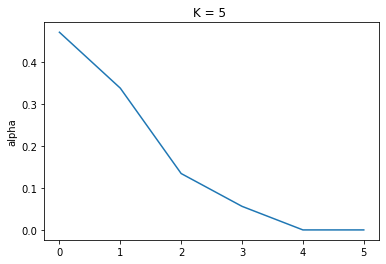

n_good 1
[[[0.         0.         0.5        0.5        0.        ]
  [0.33333333 0.         0.33333333 0.33333333 0.        ]
  [0.         0.         0.         1.         0.        ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.2        0.2        0.2        0.2        0.2       ]]

 [[0.33333333 0.33333333 0.         0.33333333 0.        ]
  [0.5        0.         0.         0.5        0.        ]
  [0.25       0.25       0.25       0.         0.25      ]
  [0.25       0.25       0.25       0.         0.25      ]
  [0.         0.         0.5        0.         0.5       ]]

 [[0.33333333 0.33333333 0.33333333 0.         0.        ]
  [0.         0.         0.         1.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.25       0.25       0.         0.25       0.25      ]
  [0.33333333 0.         0.         0.33333333 0.33333333]]

 ...

 [[0.         0.33333333 0.         0.33333333 0.33333333]
  [0.         0.5        0.        

C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:76: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:77: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 312, initial cost 6.0890e-02, final cost 2.9575e-03, first-order optimality 7.62e-07.
error 0.5074672216445133


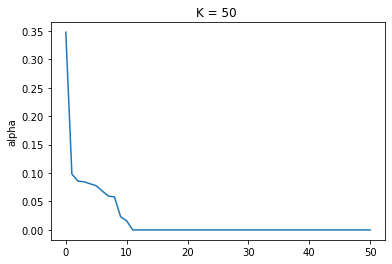

n_good 1
[[[0.33333333 0.         0.33333333 0.33333333 0.        ]
  [0.25       0.25       0.25       0.         0.25      ]
  [0.33333333 0.33333333 0.         0.33333333 0.        ]
  [0.         0.         0.         0.         1.        ]
  [0.5        0.         0.5        0.         0.        ]]

 [[0.         0.         0.5        0.         0.5       ]
  [0.33333333 0.         0.         0.33333333 0.33333333]
  [0.         0.5        0.         0.         0.5       ]
  [0.         0.33333333 0.         0.33333333 0.33333333]
  [0.         0.33333333 0.33333333 0.         0.33333333]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.33333333 0.         0.         0.33333333 0.33333333]
  [0.         0.         0.5        0.5        0.        ]
  [0.25       0.25       0.25       0.25       0.        ]]

 ...

 [[0.         0.         0.         0.         1.        ]
  [0.33333333 0.         0.33333333

C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:76: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:77: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 1225, initial cost 4.6100e-02, final cost 1.2602e-03, first-order optimality 3.69e-07.
error 0.52869107576547


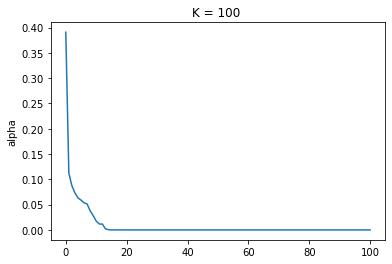

n_good 1
[[[0.33333333 0.33333333 0.         0.33333333 0.        ]
  [0.         0.33333333 0.33333333 0.         0.33333333]
  [0.25       0.25       0.25       0.         0.25      ]
  [0.25       0.25       0.25       0.25       0.        ]
  [0.         0.         0.5        0.5        0.        ]]

 [[0.         0.33333333 0.         0.33333333 0.33333333]
  [0.         0.         0.5        0.5        0.        ]
  [0.         0.33333333 0.33333333 0.         0.33333333]
  [0.         0.5        0.         0.5        0.        ]
  [0.25       0.25       0.         0.25       0.25      ]]

 [[0.         0.         0.         0.         1.        ]
  [0.25       0.25       0.25       0.25       0.        ]
  [0.         0.         0.5        0.5        0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.33333333 0.33333333 0.         0.33333333 0.        ]]

 ...

 [[0.25       0.25       0.25       0.25       0.        ]
  [0.         0.         0.        

C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:76: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:77: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 2331, initial cost 4.7228e-02, final cost 4.7353e-04, first-order optimality 1.16e-07.
error 0.2930472565968186


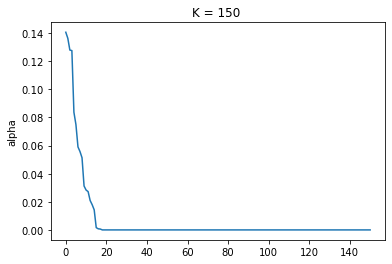

n_good 1
[[[0.33333333 0.         0.33333333 0.33333333 0.        ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.         0.         0.         0.         0.        ]
  [0.5        0.         0.         0.5        0.        ]
  [0.33333333 0.33333333 0.         0.33333333 0.        ]]

 [[0.33333333 0.         0.         0.33333333 0.33333333]
  [0.         0.         0.33333333 0.33333333 0.33333333]
  [0.5        0.         0.         0.5        0.        ]
  [0.         0.33333333 0.33333333 0.33333333 0.        ]
  [0.5        0.         0.5        0.         0.        ]]

 [[0.33333333 0.33333333 0.         0.33333333 0.        ]
  [0.25       0.25       0.25       0.         0.25      ]
  [0.         0.5        0.         0.5        0.        ]
  [0.         1.         0.         0.         0.        ]
  [0.         0.         0.         0.5        0.5       ]]

 ...

 [[0.33333333 0.33333333 0.         0.         0.33333333]
  [0.         0.         0.5       

C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:76: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:77: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 4523, initial cost 4.2045e-02, final cost 6.8634e-05, first-order optimality 3.52e-08.
error 0.5258153726946856


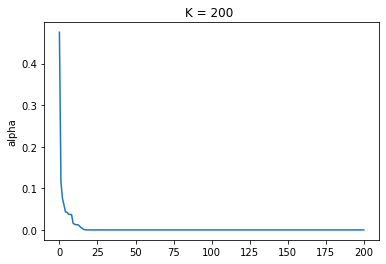

n_good 1
[[[0.33333333 0.         0.33333333 0.33333333 0.        ]
  [0.5        0.         0.5        0.         0.        ]
  [0.         0.         0.         0.5        0.5       ]
  [0.33333333 0.33333333 0.         0.         0.33333333]
  [0.25       0.25       0.25       0.25       0.        ]]

 [[0.         0.         0.         0.         1.        ]
  [0.         0.         0.         1.         0.        ]
  [0.5        0.         0.         0.         0.5       ]
  [0.         0.33333333 0.33333333 0.         0.33333333]
  [0.         0.5        0.5        0.         0.        ]]

 [[0.33333333 0.33333333 0.         0.33333333 0.        ]
  [0.5        0.5        0.         0.         0.        ]
  [0.33333333 0.         0.33333333 0.33333333 0.        ]
  [0.         0.         0.         0.         1.        ]
  [0.33333333 0.         0.33333333 0.         0.33333333]]

 ...

 [[0.25       0.25       0.25       0.25       0.        ]
  [0.25       0.25       0.25      

C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:76: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_17356/1722794238.py:77: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


In [ ]:
# k_list = np.linspace(50, 200, 5, dtype=int,endpoint=True)
k_list = [5,50,100,150,200,250,300]
# k_list = [50,50,50,50,50,50,50,50,50,50,50,50]

error_list = []
good_p_k = np.zeros([1,n,n])  
for k in k_list:
    p_k = get_p_k(n_traj=k,n_state=n,good_p_k=good_p_k)
    print(p_k)
    alpha = get_alpha(p_bar,p_k)
#     good_alpha = np.alpha(alpha > 0.03)
#     good_p_k = p_k[alpha > 0.03]
#     print("good_p_k",good_p_k)
    p_hat = get_p_hat(alpha,p_k)
    error = get_error(p_hat,Frobenius_gt)
    print("error",error)
    error_list.append(error)
    
    # sort and print alpha
    sorted_alpha = np.sort(alpha)[::-1]
    plt.plot(sorted_alpha)
    plt.ylabel("alpha")
    plt.title("K = %i " % k)
    plt.show()
    
print("error_list",error_list)


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

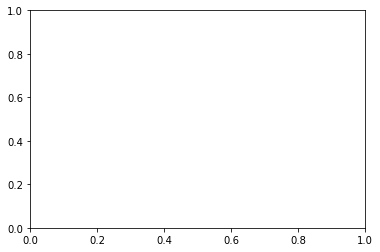

In [14]:
plt.plot(k_list,error_list)
plt.xlabel("K")
plt.ylabel("error")
plt.title("%i states " % n)
plt.show()

In [6]:
p_k = get_p_k(n_traj=800,n_state=n)
alpha = get_alpha(p_bar,p_k)
p_hat = get_p_hat(alpha,p_k)
error = get_error(p_hat,Frobenius_gt)
print("error",error)

C:\Users\Liuce\AppData\Local\Temp/ipykernel_16916/1997243371.py:44: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_16916/1997243371.py:45: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`gtol` termination condition is satisfied.
Function evaluations 274, initial cost 2.4545e-02, final cost 2.0889e-08, first-order optimality 9.87e-09.
error 0.0718683714543282
